## Отчет по техническому заданию
В задании предлагалось сделать следюущие две вещи:
1. Вам нужно определить собственные движения цены фьючерса ETHUSDT, исключив из них движения вызванные влиянием цены BTCUSDT. Опишите, какую методику вы выбрали, какие параметры подобрали, и почему.

2. Напишите программу на Python, которая в реальном времени (с минимальной задержкой) следит за ценой фьючерса ETHUSDT и используя выбранный вами метод, определяет собственные движение цены ETH. При изменении цены на 1% за последние 60 минут, программа выводит сообщение в консоль. При этом программа должна продолжать работать дальше, постоянно считывая актуальную цену.

Так как первая часть задания предполагает составление некоторого отчета и большое количество визуализаций, я посчитал уместным сделать ее в этом Jupyter ноутбоке. Конечно, это может выглядеть не совсем каннонично, но при необходимости, весь код и модели можно легко сконвертировать в питоновские файлы и работать с ними напрямую. 

Вторую часть задания я сделал в чистом питоне - файл "main.py", его вы можете найти том же репозетории, где и ноутбук.

### 1-ая часть задания
Чтобы понять, как движения фьючерса BTCUSDT влияют на движения ETHUSDT, нужно обраться к историческим данным о торговых свечах. Благо их огромное количество в разного вида источниках. Для данной задачи я решил взять исторические данные с Binance (ну а откуда же еще). Чаще всего, пользователи берут данные Binance из специального архива, в котором есть всевозможные данные для спота и фьючерсов: https://data.binance.vision . Однако при парсинге из данного источника я столкнулся с множеством неприятных подводных камней (например, часть csv файлов содержит заголовки, часть нет; некоторые данные пропущены), поэтому, чтобы сэкономить время на этом этапе и потратить его на более инетерсные части задания, я решил использовать уже очищенный и собранный датасет из следующего источника: https://www.cryptodatadownload.com/data/binance/ . Они предлагают такой же спектр данных, что и архив Binance. 

Перейдем к описанию кода. Сначала ипортируем библиотеки для обработки и визуализации данных. Далее напишем функцию, подгружающую и немного обработывающую данные о фьючерсках из выбранного источника *get_futures_historical_data*. Данная функция принимает на вход всего два параметра: имя торговой пары (*symbol*) и интервал, описыающий временной промежуток между соседними строчками в данных (*interval*). Я решил выбрать данные о дневных свечах, поэтому по умолчанию *interval* = 'day'. Также эта функция сортирует данные по значению даты (столбец *Date*), что, по очевидным причинам, критически важно для работы с временным рядами. Функция *get_futures_historical_data* представлена в яейке 2, вид полученных и отсортированных по времени датасетов для пар BTCUSDT и ETHUSDT представлены в ячейках 3 и 4 соотвественно. Датасеты содержат несколько столбцов, однако для нас, по большому счету, будут интересовать только два стобца *Open* - цена открытия свечи, *Close* - цена закрытия свечи.

In [1]:
# import libraries for data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def get_futures_historical_data(symbol: str = 'BTCUSDT', interval: str = 'day') -> pd.DataFrame:
    
    """Return a pandas dataframe with Binance Futures historical data 
    param symbol: name of a trading pair
    param interval: frequency of the requested data (e.g. for every 1 hour, every 1 day)"""
    
    # url of the data source
    url = 'https://www.cryptodatadownload.com/cdd/{symbol}_Binance_futures_UM_{interval}.csv'
    
    # upload data and convert Date column to proper dates (parse_date) 
    df = pd.read_csv(url.format(symbol=symbol, interval=interval), delimiter=",", skiprows=[0], header=0, parse_dates=[1])
        
    # set Date column as index
    df.set_index('Date', inplace=True)
    
    # drop unnecessary columns
    df.drop(['Unix', 'Symbol'], axis=1, inplace=True)
    
    # sort the dataframe by Date index
    df.sort_values('Date', inplace=True)
    
    return df

In [3]:
# BTCUSDT dataset
df_btc=get_futures_historical_data()
df_btc

,Open,High,Low,Close,Volume,Volume Base Asset,tradecount
Date,,,,,,,
2020-01-01,7189.43,7260.43,7170.15,7197.57,56801.329,4.096788e+08,101871
2020-01-02,7197.57,7209.59,6922.00,6962.04,115295.677,8.156278e+08,224747
2020-01-03,6962.34,7407.28,6863.44,7341.72,208493.458,1.507314e+09,409820
2020-01-04,7341.60,7400.00,7269.21,7350.71,92586.033,6.784024e+08,186349
2020-01-05,7350.54,7495.00,7303.00,7354.36,117765.972,8.744885e+08,238905
...,...,...,...,...,...,...,...
2023-04-29,29300.00,29443.90,29000.40,29212.70,218013.244,6.381227e+09,2326398
2023-04-30,29212.70,29950.00,29067.40,29223.00,417798.846,1.230857e+10,3831415
2023-05-01,29223.00,29325.50,27650.00,28054.40,624974.488,1.771553e+10,5751299


In [4]:
# ETHUSDT dataset
df_eth=get_futures_historical_data(symbol='ETHUSDT')
df_eth

,Open,High,Low,Close,Volume,Volume Base Asset,tradecount
Date,,,,,,,
2020-01-01,129.12,132.96,128.62,130.62,466063.929,6.103756e+07,40168
2020-01-02,130.63,130.75,126.25,127.11,523582.924,6.737797e+07,47479
2020-01-03,127.11,135.07,125.78,134.29,951123.597,1.250189e+08,106861
2020-01-04,134.31,135.80,132.41,134.14,509778.108,6.815393e+07,65138
2020-01-05,134.14,138.17,134.12,135.33,669677.687,9.109860e+07,71080
...,...,...,...,...,...,...,...
2023-04-29,1890.13,1917.27,1881.10,1907.01,1593882.469,3.028672e+09,1843721
2023-04-30,1907.01,1940.00,1863.90,1868.41,2977980.167,5.678024e+09,2825844
2023-05-01,1868.41,1885.56,1805.28,1829.97,3740379.561,6.871930e+09,3275823


Видно, что датасеты содержат неодинаковое количество строк - в данных о BTCUSDT два дня пропущены. Поэтому объединим наши датасеты с помощью inner join по столбцу *Date*, предварительно переименовав столбцы, чтобы не получить неинтерпретируемые названия в стиле Close_x и Close_y. Вид объединеного датасета представлен в ячейке 5.

In [5]:
# rename column for the following merge
df_btc.columns = [column+'_BTC' for column in df_btc.columns]
df_eth.columns = [column+'_ETH' for column in df_eth.columns]

# use inner join to merge our datasets
df = df_eth.merge(df_btc, how='inner', on='Date')
df

,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,Volume Base Asset_ETH,tradecount_ETH,Open_BTC,High_BTC,Low_BTC,Close_BTC,Volume_BTC,Volume Base Asset_BTC,tradecount_BTC
Date,,,,,,,,,,,,,,
2020-01-01,129.12,132.96,128.62,130.62,466063.929,6.103756e+07,40168,7189.43,7260.43,7170.15,7197.57,56801.329,4.096788e+08,101871
2020-01-02,130.63,130.75,126.25,127.11,523582.924,6.737797e+07,47479,7197.57,7209.59,6922.00,6962.04,115295.677,8.156278e+08,224747
2020-01-03,127.11,135.07,125.78,134.29,951123.597,1.250189e+08,106861,6962.34,7407.28,6863.44,7341.72,208493.458,1.507314e+09,409820
2020-01-04,134.31,135.80,132.41,134.14,509778.108,6.815393e+07,65138,7341.60,7400.00,7269.21,7350.71,92586.033,6.784024e+08,186349
2020-01-05,134.14,138.17,134.12,135.33,669677.687,9.109860e+07,71080,7350.54,7495.00,7303.00,7354.36,117765.972,8.744885e+08,238905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-29,1890.13,1917.27,1881.10,1907.01,1593882.469,3.028672e+09,1843721,29300.00,29443.90,29000.40,29212.70,218013.244,6.381227e+09,2326398
2023-04-30,1907.01,1940.00,1863.90,1868.41,2977980.167,5.678024e+09,2825844,29212.70,29950.00,29067.40,29223.00,417798.846,1.230857e+10,3831415
2023-05-01,1868.41,1885.56,1805.28,1829.97,3740379.561,6.871930e+09,3275823,29223.00,29325.50,27650.00,28054.40,624974.488,1.771553e+10,5751299


Теперь немножечко повизуализируем. Сначала посмотрим на движения наших пар за весь рассматриваемый временной промежуток (см. ячейку 6). Пока что на уровне интуиции кажется, что движения действительно скоррелированны, по крайней мере значимые пики цены происходят примерно в одних и тех же временных промежутках. Теперь, для наглядного отображения отскейлим цены закрытия наших фьючей с помощью логарифма и сравним их движения на отдельном графике (см. ячейку 7). Теперь хорошо видно, что характер движения двух пар действительно сильно схож. 

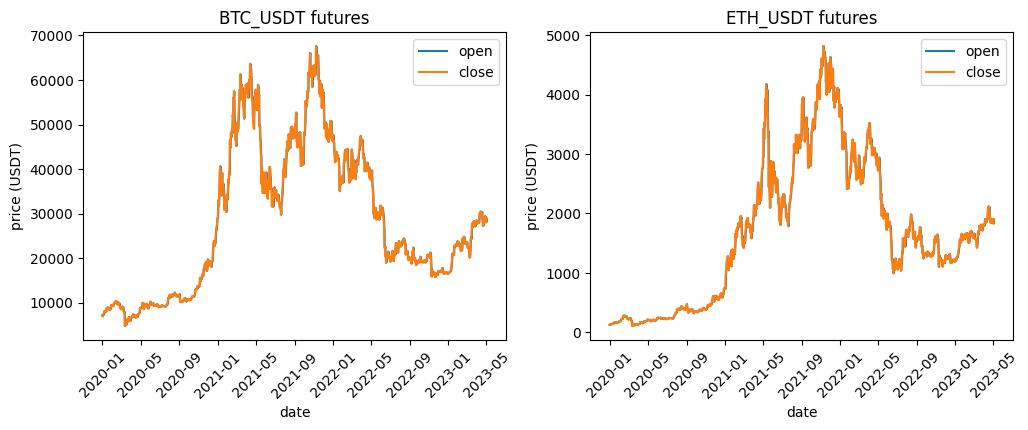

In [6]:
# plot open and close prices for BTC and ETH 
plt.figure(figsize = [12, 4])

# BTC
plt.subplot(1, 2, 1)
plt.plot(df['Open_BTC'])
plt.plot(df['Close_BTC'])
plt.title('BTC_USDT futures')
plt.ylabel('price (USDT)')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.legend(['open', 'close'], loc='upper right')

# ETH
plt.subplot(1, 2, 2)
plt.plot(df['Open_ETH'])
plt.plot(df['Close_ETH'])
plt.title('ETH_USDT futures')
plt.ylabel('price (USDT)')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.legend(['open', 'close'], loc='upper right')
plt.show()

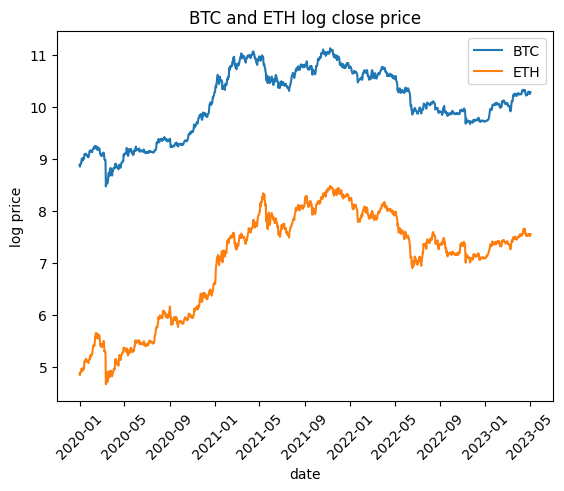

In [7]:
# assign speical vatiables to the names of the considered columns 
btc_close='Close_BTC'
eth_close='Close_ETH'

# take logarithm of ETH and BTC prices for scalling
log_btc_price = np.log(df[btc_close])
log_eth_price = np.log(df[eth_close])

# plot log close prices
plt.plot(log_btc_price)
plt.plot(log_eth_price)
plt.title('BTC and ETH log close price')
plt.ylabel('log price')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.legend(['BTC', 'ETH'], loc='upper right')
plt.show()

Теперь посмотрим на интересующую нас величину - относительные изменения цен фьючерсов (движения цен). Будем рассматривать цену закрытия свечей. Для этого с помощью встроенного в pandas метода *pct_change* посчитаем относительную разницу между каждой строчкой данных столбца *Close* и предыдущей строчкой этого же столбца (ячейка 8). Визуализируем полученные движения для обеих пар на всем временном промежутке (ячейка 9). Видно, что относительные изменения цен тоже достаточно неплохо скоррелированы, хотя, конечно же, наблюдаются и отличия, которые, по большоу счету и являются сосбственным движениями цены ETH.

In [8]:
# calculate relative difference (in %) between each column value and the previous column value (previous timestamp)
# dopna needed to delete the first NaN value (no difference)
movements_btc_close = df[btc_close].pct_change().dropna() * 100  
movements_eth_close = df[eth_close].pct_change().dropna() * 100

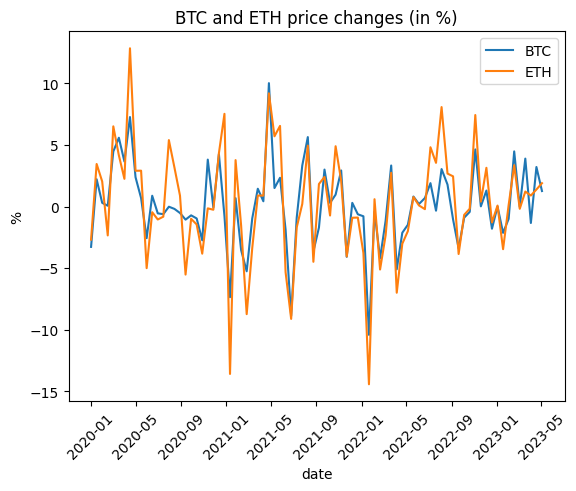

In [9]:
# plot BTC and ETH close price changes (in %)
plt.plot(movements_btc_close[::15]) # for better representation takes every 15th value
plt.plot(movements_eth_close[::15]) # for better representation takes every 15th value
plt.title('BTC and ETH price changes (in %)')
plt.ylabel('%')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.legend(['BTC', 'ETH'], loc='upper right')
plt.show()

Заканчивая с визуалцией, построим относительные изменения цены ETH как функцию изменения цены BTC, чтобы пронаблюдать наличие корреляции (ячейка 10). Картинка, как и ожидалось, явно демонстрирует влияние изменений цены BTC на изменения ETH. Однако, на графике четко видны выбросы в данных (например точка -40 по оси х), что негативно скажется на работе выбранного мною метода для исключения влияния цены BTC (будет описан ниже). В связи с этим, я позволю себе избавиться от них в ячейке 11 и построю тот же самый график, но без учета выбросов, в ячейке 12.

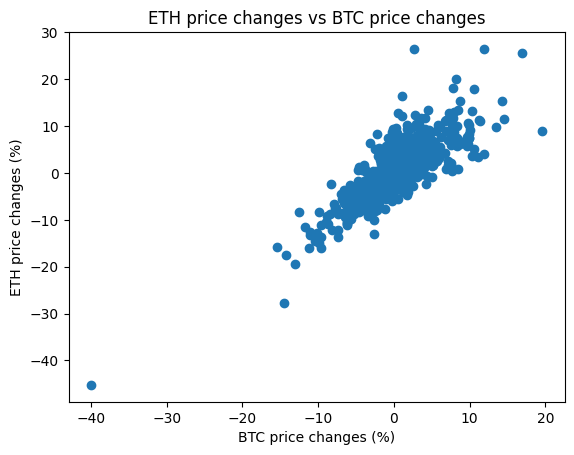

In [10]:
# plot ETH price changes vs BTC price changes (in %)
plt.plot(movements_btc_close, movements_eth_close, 'o')
plt.ylabel('ETH price changes (%)')
plt.xlabel('BTC price changes (%)')
plt.title('ETH price changes vs BTC price changes')
plt.show()

In [11]:
# remove outliers from ETH price changes and take corresponidng values from BTC price changes (not to break the order)
movements_eth_close=movements_eth_close.loc[lambda x: abs(x)<=20]
movements_btc_close=movements_btc_close.loc[movements_eth_close.index]

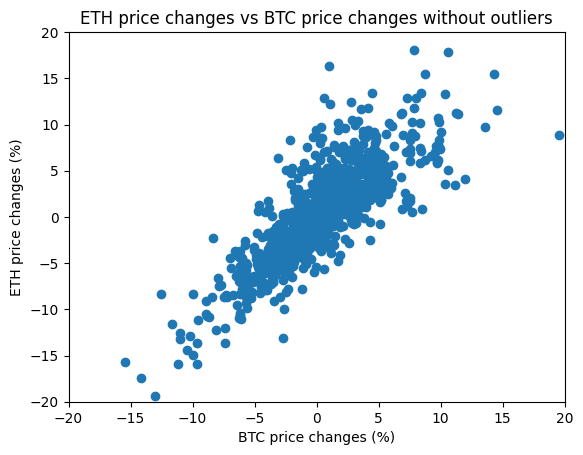

In [12]:
# plot ETH price changes vs BTC price changes (in %) without outliers
plt.plot(movements_btc_close, movements_eth_close, 'o')
plt.ylabel('ETH price changes (%)')
plt.xlabel('BTC price changes (%)')
plt.title('ETH price changes vs BTC price changes without outliers')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.show()

Скажу пару слов о коэффициенте корреляции. Ссылаясь на статьи: https://habr.com/ru/articles/542638/; https://distrland.blogspot.com/2021/07/blog-post_15.html, могу отметить, что расчет "привычного" коэффициента корреляции в случае временных рядов (как раз наша история) может привести (и часто приводит) к неверным результатам. В частности, можно получить статистически занчимую корреляцию между рядами, которые, в силу здравого смысла, скоррелированными быть никак не могут. Для того, чтобы получать коэффициент по стандартной формуле, временные ряды должны быть стационарны, то есть распределение величины и его параметры должны не зависесть от времени (что опять-таки встречается крайне редко). Для обхода данной проблемы применяют различные трюки по приведению рядов к станцонарному виду. Эта процедура нетривиальная и отнимает немало ресурсов, поэтому для данной задачи мы ограничимся демонстарцией скоррелированности "по картинке".

Наконец, перейдем к описанию метода, который я выбрал для исключения влияния цены BTC. На самом деле он достаточно прост - банальная линейная регрессия. Дело в том, что на графике из ячейки 12 четко видно, что связь между изменением цены BTC и цены ETH хорошо описывается линейной функцией, поэтому вопрос выбора модели в прицнипе отпадатает сам собой. Хочу отметить несколько важных моментов: 
1. Наш таргет (y) - это относительные изменения цены ETH
2. Фича у нас всего одна (x) - относительные изменения цены BTC
3. Мы будем строить модель вида y = a*x, не добавляя свободный член, так как он может превести к завышенным оценкам влияния BTC
4. Собственные изменения цены ETH буду расчитываться как y_independent = y - a*x

Перед построением модели посмотрим на распределине таргета, так как часто оно помогает понять, как примерно будет вести себя модель, какие метрики лучше брать и др. Распределение относительных изменений цены ETH изображено на графике ниже (ячейка 13). В целом, распределение не кажется экстроординарным: оно близко к симметричному (что обычно хорошо для регрессии) и даже "неплохо" ложится на нормальное распределине. Я специально выделил в ковычки слово "неплохо", так как визуально оценивать близость распределений конечно неправильно, поэтому для более формальной оценки применим тест Шапиро-Вилка (ячейки 14 и 15). К сожалению, гипотеза о нормальной распределнности нашего таргета была отвергнута, p-value получилось слишком уж маленьким. Данный факт печален для стандартной линейной регрессии, так как она гораздо лучше работает с нормально распределенным таргетом, но в остальном распределение выглядит хорошо и в целом можно не бояться за использование данной модели. По поводу метрик для оценки, так как распределение симметрично и без явных выбросов, можно применять любой стандартный вариант: MSE, MAE, RMSE и др.

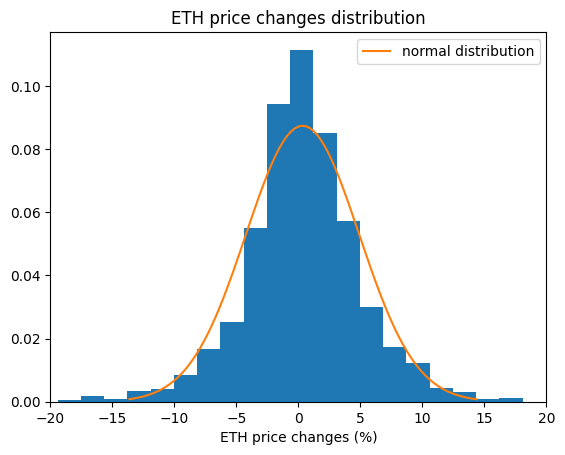

In [13]:
# plot ETH price changes distribution
plt.hist(movements_eth_close, bins=20, density=True)
plt.title("ETH price changes distribution")
plt.xlabel("ETH price changes (%)")

# sample values from normal distribution with mean and std from ETH price changes
mean=movements_eth_close.mean()
std=movements_eth_close.std()
np.random.RandomState(seed=42)
x = np.random.normal(loc = mean, scale = std, size=2500)
x_sorted = np.sort(x)

# plot theoretical normal distribution with the given mean and std
plt.plot(x_sorted, stats.norm.pdf(x_sorted, loc=mean, scale=std))
plt.xlim(-20,20)
plt.legend(['normal distribution'], loc='upper right')
plt.show()

In [14]:
def shapiro_test(data: pd.Series, alpha: float) -> tuple:
    
    """Performs Shapiro-Wilk test. The null hypothesis is the data was drawn from a normal distribution
    param data: the data for which the test is performed
    param alpha: significance value to reject the null hypothesis"""
    
    # perform Shapiro-Wilk test using SciPy stats
    stat, p_value = stats.shapiro(data)
    if p_value < alpha:
        print("Reject the null hypothesis: {p_value} < {alpha}".format(p_value=p_value, alpha=alpha))
        print("Data is not normally distributed")
        
    else:
        print("Fail to reject the null hypothesis: {p_value} >= {alpha}".format(p_value=p_value, alpha=alpha))
        print("Data is normally distributed")
        
    return (stat, p_value)



In [15]:
shapiro_test(movements_eth_close, 0.05)

Reject the null hypothesis: 1.6435018276861335e-11 < 0.05
Data is not normally distributed


(0.9809840321540833, 1.6435018276861335e-11)

Перейдем к построению моделей линейной регрессии. Я решил выбрать два вида: OLS и Ridge, сравнить их на тестовой выборке и выбрать лучшую для использования в второй части задания. Функция *train_test_split* последовательно (по дате) делит выборки на трейн и тест (ячейка 16). Стандартный сплит со случайном перемешиванием данных для временных рядов не годится. В ячейке 18 я строю обе модели и сравниваю их качество на трейн сете по коэффициенту R2, a на тесте сете по RMSE. По результатам сравнения у нас нет победителя, модели показали себя примерно одинаково на обоих сетах, поэтому можем взять любую из них - например, OLS.

In [16]:
def train_test_split(X, y, test_size: float = 0.2) -> tuple:
    
    """Peforms splitting of the given data on the train and test sets in the sequential order
    param X: features data
    param y: target data
    test_size: portion of the entire data used as the test set"""
    
    # create numpy array and reshape the data to the form appropriate for sklearn 
    X = np.array(X).reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)   
    
    # count the index in the data, after which the test set begins
    test_index = int(len(X)*(1-test_size))
    
    # splitting
    X_train = X[:test_index]
    y_train = y[:test_index]
    X_test = X[test_index:]
    y_test = y[test_index:]
    
    print("Size of the train data: {}".format(len(X_train)))
    print("Size of the train data: {}".format(len(X_test)))
          
    return X_train, X_test, y_train, y_test

In [17]:
# split on the train and test sets
X_train, X_test, y_train, y_test = train_test_split(movements_btc_close, movements_eth_close)

Size of the train data: 968
Size of the train data: 242


In [18]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

# fit and evaluate Ordinary Least Squares Linear Regression
ols = LinearRegression(fit_intercept=False).fit(X_train, y_train)
print("OLS: R2 on the train set = {}".format(ols.score(X_train,  y_train)))
print("OLS: RMSE on the test set = {}".format(mean_squared_error(y_test, ols.predict(X_test), squared=False)))

print("============================")

# fit and evaluate Ridge Linear Regression
ridge = Ridge(alpha=1, random_state=42, fit_intercept=False).fit(X_train, y_train)
print("Ridge: R2 on the train set = {}".format(ridge.score(X_train,  y_train)))
print("Ridge: RMSE on the test set = {}".format(mean_squared_error(y_test, ridge.predict(X_test), squared=False)))

OLS: R2 on the train set = 0.647017254148331
OLS: RMSE on the test set = 1.7586358355787666
Ridge: R2 on the train set = 0.6470172504289426
Ridge: RMSE on the test set = 1.7586459416406401


In [19]:
# print out regression coefficients 
print("Slope = {}".format(ols.coef_[0][0]))

Slope = 1.0454451069704271


Посмотрим на то, как изменились движения цены ETH после исключения влияния BTC (ячейка 20). Из рисунка видно, что корреляция действительно пропала, теперь изменения цены ETH по отношению к изменениям цены BTC выглядят как облако точек без явного тренда.

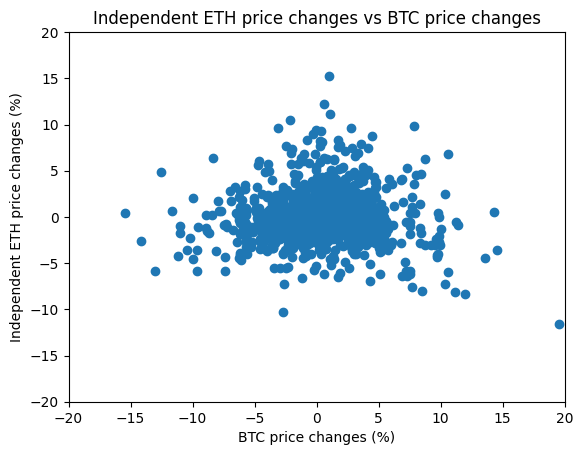

In [20]:
# calculate independent ETH price movements
influence_btc = ols.predict(np.array(movements_btc_close).reshape(-1, 1)).reshape(len(movements_btc_close), )
independent_eth_movements = movements_eth_close - influence_btc

# plot independent ETH price changes vs BTC price changes
plt.plot(movements_btc_close, independent_eth_movements, 'o')
plt.ylabel('Independent ETH price changes (%)')
plt.xlabel('BTC price changes (%)')
plt.title('Independent ETH price changes vs BTC price changes')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.show()

Сохраним OLS модель для использования во второй части задания.

In [21]:
# save OLS model 
import pickle
filename = "ols.pickle"
pickle.dump(ols, open(filename, "wb"))

## Часть 2 в файле "main.py"